<!-- PS5E02 -->

<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: left; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    When I was backpacking through Western Europe<br>
</div>

<div style="text-align: center;">
  <img src="https://i.imgur.com/QGuPmgY.jpg" alt="Centered Image" style="max-width: 60%; height: auto;">
</div>

Photo de <a href="https://unsplash.com/fr/@cel_?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Celine Ylmz</a> sur <a href="https://unsplash.com/fr/photos/restaurant-avec-guirlandes-lumineuses-L2ost-ZEmK8?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Challenge Overview</div>

<h1 style="color:red;">
- The aim is to predict the price of backpacks<br>
- The multivariables plots seems to indicate that the Price column is only noise!<br>
- See this discussion: <a href="https://www.kaggle.com/competitions/playground-series-s5e2/discussion/560669" style="color:red;">The target is just noise?</a><br>
- See the code below as a placeholder template but no need to do too much work on this competition for now.
</h1>

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Competition</div>

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Notebook aim</div>

- EDA
- LLM automation
- Model baeline
- Models tracking

In [1]:
import sys
print(sys.version)

3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


In [2]:
!pip install ray==2.10.0 autogluon.tabular  > /dev/null 2>&1
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1
!pip install sweetviz > /dev/null 2>&1
!pip install numba==0.58.1 visions==0.7.5 pandas==1.5.3 ydata-profiling==4.7.0 > /dev/null 2>&1

In [3]:
# General Purpose Libraries
import logging
import tempfile
import json
import re

# Data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

# Auto EDA
import sweetviz as sv
from ydata_profiling import ProfileReport

# LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import Markdown, display, IFrame

# Feature engineering
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from featuretools import dfs, EntitySet

# Auto ML
from autogluon.tabular import TabularPredictor

# supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import pkg_resources
import importlib

# List of packages from your imports
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scipy",
    "sweetviz",
    "ydata-profiling",  # for ProfileReport
    "langchain-core",
    "langchain-openai",
    "ipython",
    "scikit-learn",     # for sklearn imports
    "featuretools",
    "autogluon.tabular"
]

# Create requirements.txt content
requirements = []
for package in packages:
    try:
        # Handle special cases
        if package == "autogluon.tabular":
            package = "autogluon"
        
        # Get the package version
        version = pkg_resources.get_distribution(package).version
        requirements.append(f"{package}=={version}")
    except pkg_resources.DistributionNotFound:
        print(f"Warning: Package {package} not found")
        requirements.append(package)

# Write requirements to file
with open("requirements.txt", "w") as f:
    f.write("\n".join(requirements))

In [5]:
TIME_LIMIT = 3600 * 0.1

In [6]:
MODEL = 'o3-mini'

In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openai_key")

In [8]:
# Define the LLM model using LangChain
model = ChatOpenAI(
    model=MODEL,
    api_key=OPENAI_API_KEY
)

In [9]:
# Define the prompt template for LangChain
template_eda = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

In [10]:
# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()
            
# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }
    
    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA</div>

In [11]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')

In [12]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [13]:
test_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [14]:
sample_submission.head()

,id,Price
0,300000,81.411
1,300001,81.411
2,300002,81.411
3,300003,81.411
4,300004,81.411


In [15]:
train_data.shape

(300000, 11)

In [16]:
test_data.shape

(200000, 10)

In [17]:
train_data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


In [18]:
test_data.describe()

,id,Compartments,Weight Capacity (kg)
count,200000.000000,200000.000000,199923.000000
mean,399999.500000,5.442855,17.993033
std,57735.171256,2.888740,6.972079
min,300000.000000,1.000000,5.000000
25%,349999.750000,3.000000,12.068875
50%,399999.500000,5.000000,18.054750
75%,449999.250000,8.000000,23.965700
max,499999.000000,10.000000,30.000000


In [19]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

target_vars = list(train_columns - test_columns)

if len(target_vars) == 1:
    target = target_vars[0]
    print(f"Identified target variable: {target}")
else:
    raise ValueError(f"Expected a single target variable, but found: {target_variable}")

Identified target variable: Price


## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA report with Sweetviz</div>

In [20]:
# Generate the report with Sweetviz
target_variable = target_vars[0]
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat=target_variable)
report_path = 'Comparative_EDA_Report.html'
report.show_html(filepath=report_path, open_browser=False)

# Display the report inline in Kaggle
IFrame(src=report_path, width=1000, height=600)

                                             |          | [  0%]   00:00 -> (? left)

Report Comparative_EDA_Report.html was generated.


## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA report with YData Profiling</div>

In [21]:
# Generate Pandas Profiling report for the training data
profile_train = ProfileReport(train_data, title="Train Data Profile Report", explorative=True)
profile_train_path = 'Train_Data_Profile_Report.html'
profile_train.to_file(profile_train_path)

# Display the training report inline in Kaggle
display(IFrame(src=profile_train_path, width=1000, height=600))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Generate Pandas Profiling report for the test data
profile_test = ProfileReport(test_data, title="Test Data Profile Report", explorative=True)
profile_test_path = 'Test_Data_Profile_Report.html'
profile_test.to_file(profile_test_path)

# Display the test report inline in Kaggle
display(IFrame(src=profile_test_path, width=1000, height=600))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA with Langchain</div>

In [23]:
summary = eda_summary(train_data)
summary_json = json.dumps(summary, indent=4, default=str)

In [24]:
# Define the prompt template for LangChain
template = """Provide an analysis of the following EDA summary, The aim of this dataset and EDA is to understand how several variables influence depression.
Ultimately the aim is to build a classification model to predict depression:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
display(Markdown(result))

Below is an analysis of the provided EDA summary, along with key observations and considerations:

1. Overall Dataset Structure and Completeness  
 • The dataset is large, with 300,000 rows and 11 columns.  
 • Out of all cells, only about 1.73% are missing (57,199 missing values overall). This is relatively low and suggests that with proper imputation or handling, data quality should not be a major obstacle.  
 • The missing rates for individual columns range mostly between 2–3% for several categorical features (e.g., Brand, Material, Size, Laptop Compartment, Waterproof, Style, Color). Two numerical features (“Weight Capacity (kg)” and “Price”) have virtually no missing values.

2. Data Types and Variability  
 • There is a mix of numerical and categorical variables. The features such as Compartments, Weight Capacity (kg), and Price are numerical, while the others are categorical.  
 • The categorical features have a limited number of unique values (e.g., Brand has 5 unique counts, Material 4, Size 3, etc.), indicating that these variables have low cardinality. This can be advantageous when encoding them later for a classification model.

3. Numerical Distributions  
 • The summary statistics for numerical columns (like count, mean, std, percentiles, etc.) are not provided in detail. However, based on the skewness and kurtosis values:  
  – The distributions for the id field, Compartments, Weight Capacity (kg), and Price have skewness values near 0.  
  – The kurtosis values are slightly negative (around –1.14 to –1.24), which suggests that the distributions are somewhat platykurtic (flatter than a normal distribution).  
 • These values indicate that the numeric features are relatively symmetric, making them less likely to need complex transformations for many statistical or machine learning models.

4. Correlation Insights  
 • The correlation matrix among the numeric features shows extremely low correlations (all coefficients are near 0). For example, the Price shows a maximum correlation of only 0.018 with Weight Capacity (kg).  
 • This suggests that there are effectively no strong linear relationships among the numerical predictors. In a modeling context, multicollinearity is likely not a concern from the available numerical features.

5. Outlier Analysis  
 • The outlier analysis reports zero outliers for id, Compartments, Weight Capacity (kg), and Price.  
 • This could indicate that the numeric features are well-behaved and do not contain extreme values that might unduly influence model training. However, context (and the method used to define outliers) is always important, so reexamining this after further data cleaning might be useful.

6. Discrepancy Note on the Study Aim  
 • The top-level description mentions that the aim of the analysis is to understand how several variables influence depression and eventually to build a classification model to predict depression. At the same time, the variables listed (such as Brand, Material, Size, etc.) do not obviously map onto common predictors of depression and instead hint at a dataset that might be related to products (perhaps backpacks or bags).  
 • It is important to clarify if the “depression” target variable is part of a merged dataset or if it is addressed elsewhere in your analysis. Ensuring that all relevant features (including any psychological or behavioral measures) are correctly integrated will be essential for the intended predictive modeling.

7. Considerations for Further Analysis and Modeling  
 • Missing Data: Although overall missingness is low, consider carefully chosen imputation strategies (or even using “missing” as a level in categorical encoding) for the affected categorical features.  
 • Feature Engineering:  
  – With low cardinality in the categorical features, encoding techniques like one-hot encoding or ordinal encoding (if there is a meaningful order) might be effective.  
  – Since the correlations between numeric features are negligible, combining features or adding interaction terms may be necessary if you suspect non-linear relationships.  
 • Data Cleaning:  
  – Verify whether the “id” feature or other identifiers are needed for prediction or should be excluded.  
  – Resolve the discrepancy between the dataset description (which is product-focused) and the predictive target (depression), verifying that the appropriate target variable and associated predictor variables are used.
 • Modeling Implications:  
  – For building a classification model (predicting depression), aside from handling missing values and encoding categorical variables, it is crucial to incorporate domain-specific features relevant to depression.  
  – Consider additional exploratory analyses on the target variable when it is included (distribution, class imbalance, etc.) to plan techniques like stratified sampling or resampling if imbalances are present.

In summary, the EDA reveals a well-structured dataset with low missing percentages and no problematic outliers. The numerical features appear to be normally distributed without any linear dependency issues. The main considerations moving forward will be to ensure that the data actually tie into the prediction of depression (especially given the mismatch observed in the variable names) and to decide on the appropriate strategies for processing categorical variables and integrating domain-relevant features before building a robust classification model.

In [25]:
# Define the prompt template for LangChain
template_features = """Provide an analysis of the following EDA summary and offer advice on feature engineering to improve predictions of Price:
{context}

Feature Engineering Recommendations for tree-based models:
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
display(Markdown(result))

Below is an analysis of the EDA summary followed by several feature engineering recommendations tailored toward improving tree‐based predictions of Price.

─────────────────────────────  
1. Analysis of the EDA Summary

a) Data Structure and Missing Values  
 • The dataset has 300,000 rows and 11 columns. Most columns have low missing rates (typically roughly 2–3%), with a few exceptions (e.g., Color at about 3.32%).  
 • The missing values occur predominantly in categorical columns (Brand, Material, Size, Laptop Compartment, Waterproof, Style, Color), so careful imputation or explicit missing flag creation will be important.  
 • Numerical columns (Compartments, Weight Capacity (kg), and Price) have virtually no missing data, which is good for continuity.

b) Data Types and Distributions  
 • The dataset contains a mix of numerical (Compartments, Weight Capacity, Price, and id) and categorical features.  
 • Many key predictors (e.g., Brand, Material, Size, Waterproof, Style, Color) are categorical. For tree-based algorithms, these can be encoded either via one-hot, label, or even target-encoding depending on the nature of the variable.  
 • The EDA shows that Price (the target variable) as well as other numerical features have near-zero skew and slight platykurtic distributions (kurtosis values around –1.2); this suggests that the raw distributions aren’t particularly heavy-tailed and may not require transformation for linear models—but tree-based methods are generally robust to these distributions.

c) Relationships and Correlations  
 • The computed correlations are very low between Price and the available numerical predictors (e.g., Weight Capacity with Price correlates at only about 0.018) indicating that simple linear relations among these features and Price are weak.  
 • This low correlation hints that non-linear interactions or combinations of features (especially those involving categorical variables) might play a more important role in predicting Price.
  
d) Outlier Analysis  
 • No significant outliers were detected in any of the columns, so there is little immediate need for outlier transformation or robust scaling for these features.

─────────────────────────────  
2. Feature Engineering Recommendations for Tree‐Based Models

Tree-based methods (e.g., Random Forests, Gradient Boosting Machines) naturally handle non-linearities and mixed data types, but careful feature engineering can still help improve model performance. Consider the following strategies:

A. Imputation & Missing Value Treatment  
 • Instead of dropping rows with missing categorical data, impute them by either:  
  – Replacing missing values with a “Missing” category (especially useful if missingness might carry its own signal).  
  – Imputing with the most frequent (mode) value if it makes sense contextually.  
 • For each categorical column with missing values, you could also create a binary flag (e.g., Brand_missing) indicating whether a value was missing. These flags sometimes capture hidden patterns related to Price.

B. Encoding Categorical Variables  
 • For categorical variables with few unique categories (e.g., Brand: 5 unique values; Material: 4; Size: 3; Waterproof and Laptop Compartment: binary), consider one-hot encoding or leave them as ordinal labels if applicable.  
 • If any categorical feature naturally has an order (for instance, if “Size” implies an order like Small, Medium, Large), use ordinal encoding to preserve that order.  
 • Experiment with target (mean-price) encoding. For instance, replacing each category with the average Price for that category might introduce a signal especially if pricing strongly depends on brand reputation or material quality. (Be cautious to perform target encoding in a cross-validated manner to avoid leakage.)

C. Creating Interaction and Ratio Features  
 • Since neither Compartments nor Weight Capacity individually shows strong correlation with Price, consider interactions. For example:  
  – Create a new feature like “Capacity per Compartment” by dividing Weight Capacity (kg) by Compartments (after ensuring you handle any zero compartments gracefully). This may capture average load per compartment.  
  – Construct interaction terms between relevant categorical features such as Brand × Material or Waterproof × Style. Although tree-based models implicitly capture interactions, explicitly introducing them can sometimes help the model learn stronger signals, especially when the unique combinations have clear price implications.

D. Aggregated or Derived Features  
 • Consider grouping categories if domain knowledge suggests some groups are similar in their price impact. For example, if some brands or materials share similar pricing strategies, an aggregated “premium vs. standard” indicator could reduce noise.  
 • Generate “missing count per row” as a numeric feature. The total number of missing categorical values per row might itself be correlated with special cases or product segments.

E. Feature Scaling and Transformation  
 • While tree-based models are not highly sensitive to the scale of numerical features, ensuring that engineered interaction features (e.g., Capacity per Compartment) do not result in extreme values is still advisable.  
  – Consider winsorizing or clipping if any engineered ratio appears too volatile, though the outlier analysis suggests this might not be a major issue.

F. Domain-Specific Considerations  
 • Think about potential real-world relationships. For instance, if waterproof functionality or laptop compartment availability is associated with higher prices (even if the raw correlations aren’t high), combine them with brand and style to gauge a “premium functional” indicator.  
 • Explore whether the “Color” feature correlates with seasonality or trend aspects in pricing if additional temporal or market data becomes available.

─────────────────────────────  
3. Final Thoughts

By addressing missing values carefully, encoding categorical features in a way that preserves their information, and exploring meaningful interactions—especially between features like compartments and weight capacity—you may uncover non-linear relationships that better predict Price. In tree-based models, explicit feature engineering (like creating relevant ratios or aggregated indicators) can help the model split the data more effectively and thus improve predictive performance. Always validate any engineered feature’s usefulness via cross-validation and feature importance analysis to ensure it contributes positively to the precision and robustness of the model.

These steps will give you a strong foundation for improving predictions of Price using tree-based methods.

```python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_data is your DataFrame and 'id' is one of its columns.
cols_to_plot = [col for col in train_data.columns if col != 'id']

# Set a style for consistency
sns.set(style="whitegrid")

for col in cols_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # If the column is numeric: plot histogram and boxplot
    if pd.api.types.is_numeric_dtype(train_data[col]):
        # Left subplot: Histogram (deep blue)
        axes[0].hist(train_data[col].dropna(), bins=30, color='darkblue', edgecolor='black')
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')
        
        # Right subplot: Boxplot (orange)
        sns.boxplot(x=train_data[col].dropna(), ax=axes[1], color='orange', fliersize=3)
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)
    else:
        # For categorical variables:
        # Left subplot: Count plot (bar plot with deep blue bars)
        sns.countplot(x=train_data[col], ax=axes[0], color='darkblue')
        axes[0].set_title(f'Count Plot of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')
        
        # Right subplot: Pie chart of value counts (using pastel colors)
        value_counts = train_data[col].value_counts()
        axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=sns.color_palette('pastel'))
        axes[1].set_title(f'Pie Chart of {col}')
    
    plt.tight_layout()
    plt.show()
```

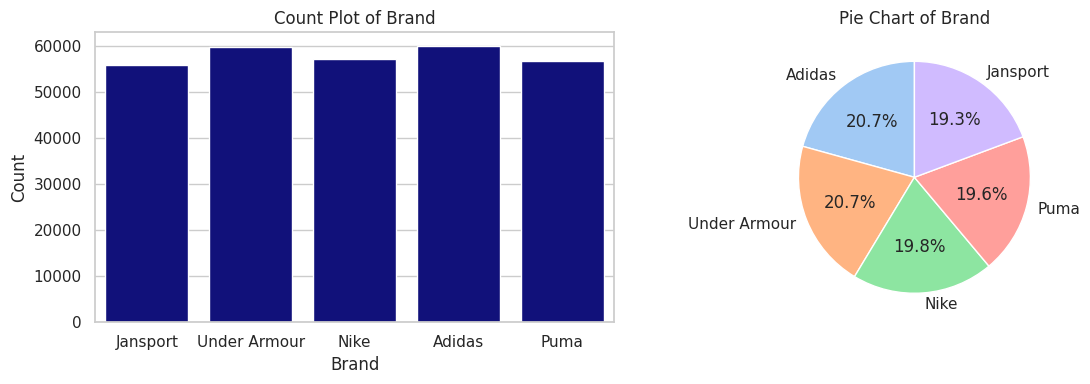

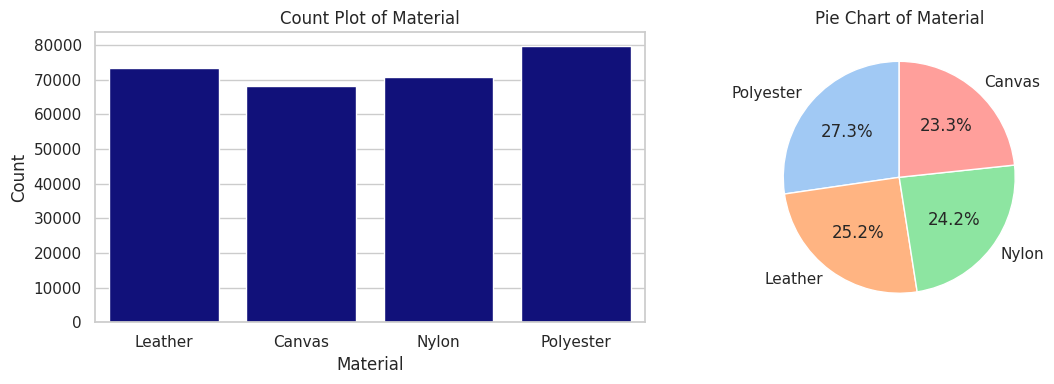

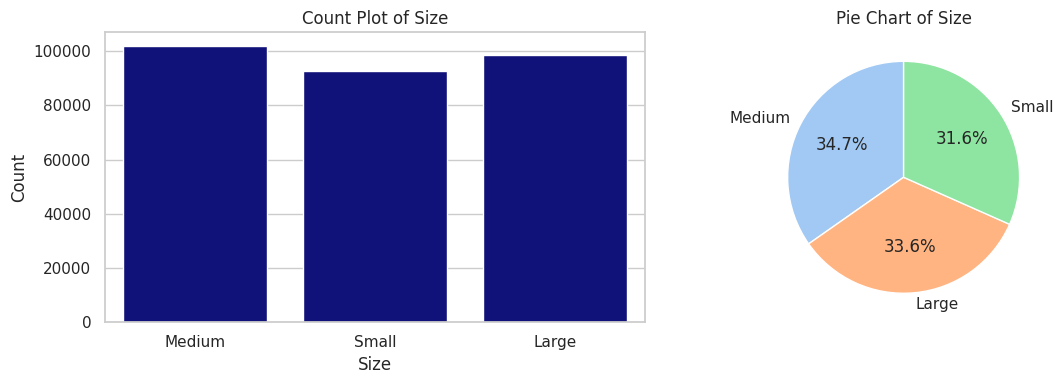

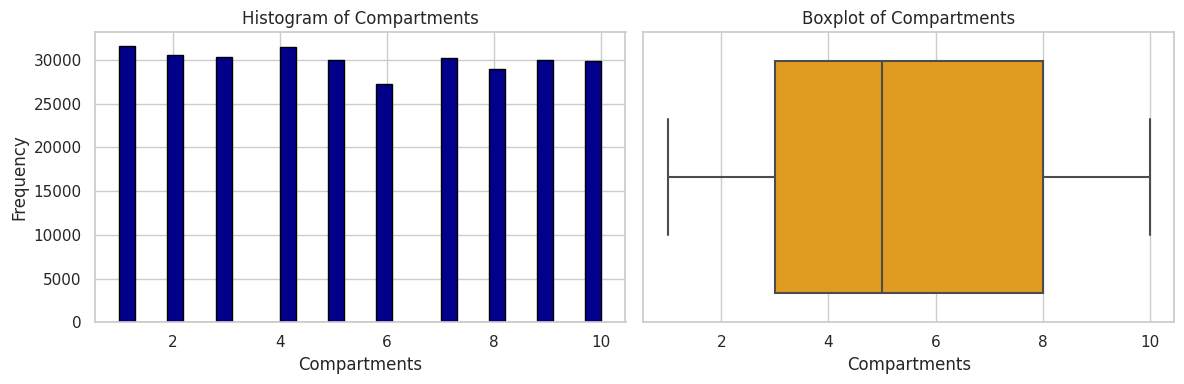

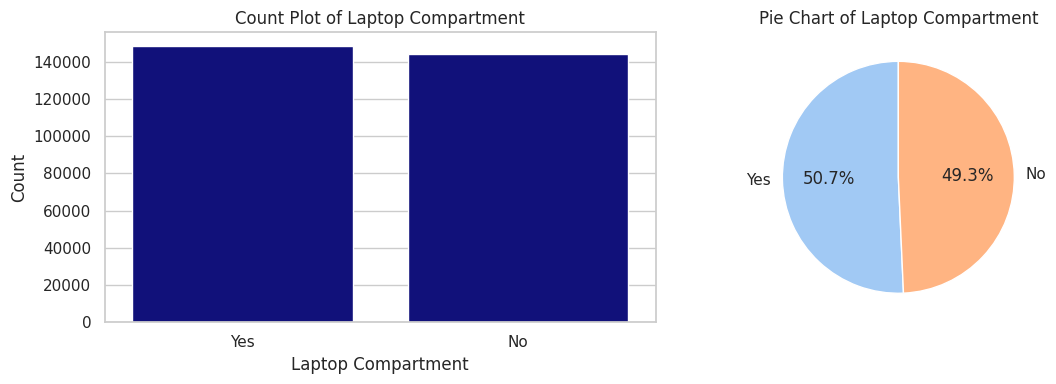

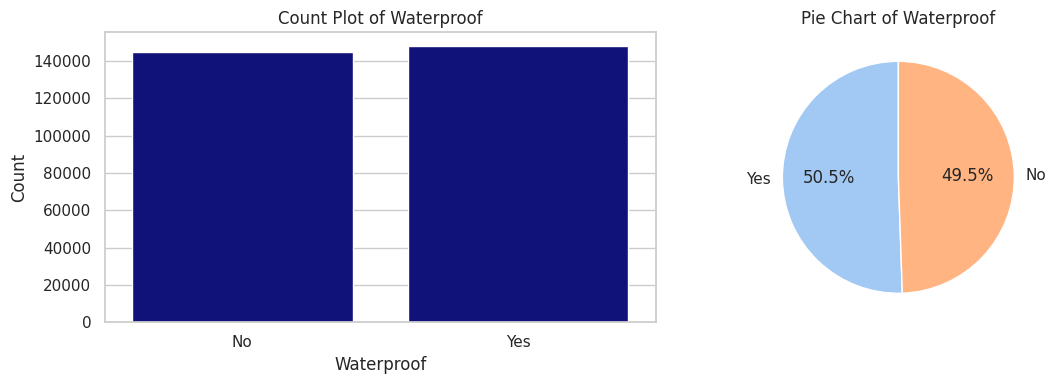

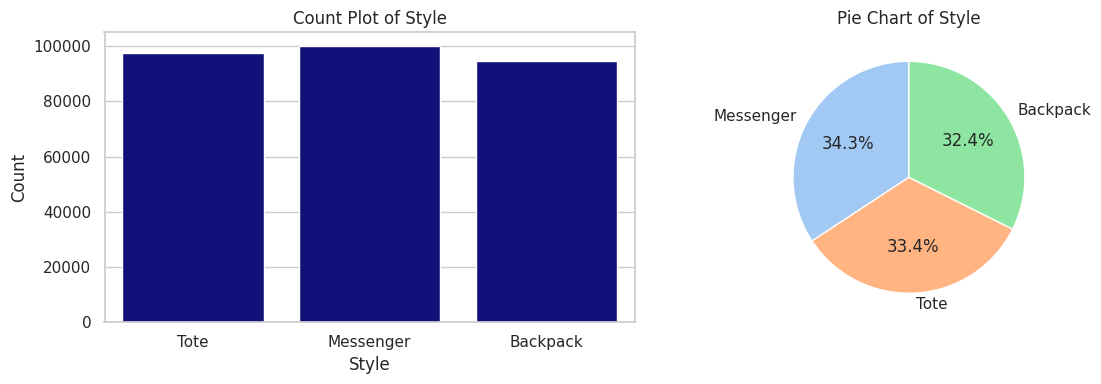

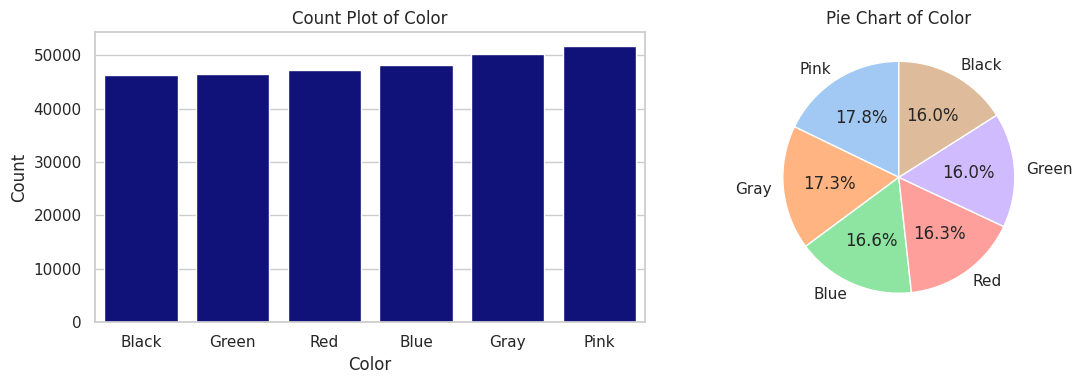

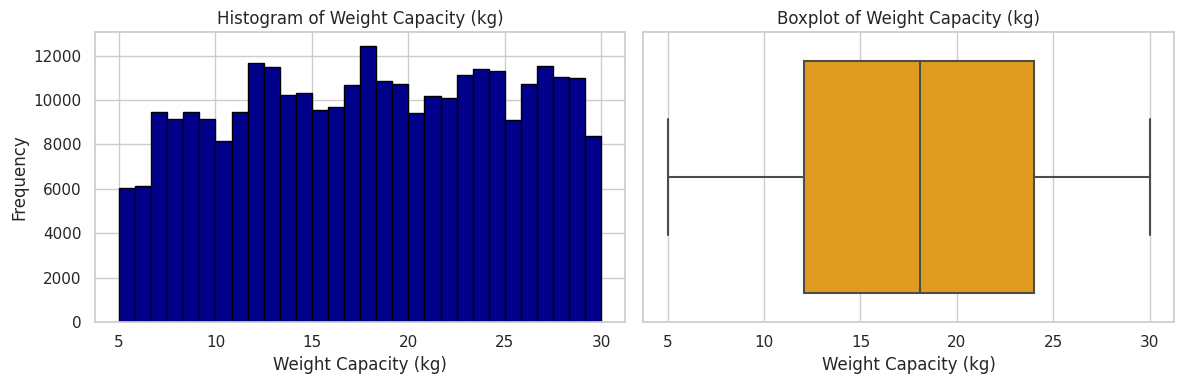

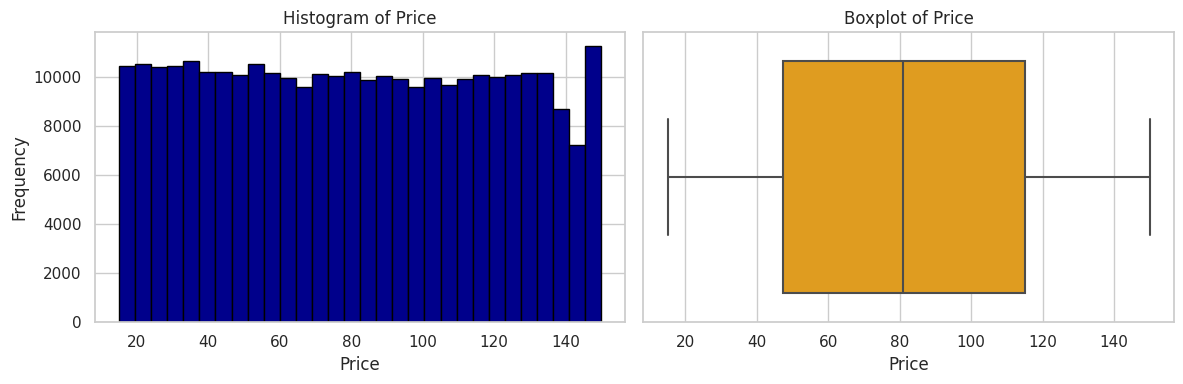

In [26]:
# warning when adding code template to the prompt you have to be careful about the formating. If the code is place as is in the template some might be
# interpreted as variables by the langchain prompt parser

code_template = """
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_data is your DataFrame and 'id' is one of its columns.
cols_to_plot = [col for col in train_data.columns if col != 'id']

# Set a style for consistency
sns.set(style="whitegrid")

for col in cols_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(train_data[col]):
        # Left subplot: Histogram (deep blue)
        axes[0].hist(train_data[col].dropna(), bins=30, color='darkblue', edgecolor='black')
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Right subplot: Boxplot (orange)
        sns.boxplot(x=train_data[col].dropna(), ax=axes[1],
                    color='orange', fliersize=3,
                    boxprops={{'facecolor': 'orange'}})
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)
    else:
        # For categorical variables:
        # Left subplot: Count plot (bar plot)
        sns.countplot(x=train_data[col], ax=axes[0], color='darkblue')
        axes[0].set_title(f'Count Plot of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')

        # Right subplot: Pie chart
        value_counts = train_data[col].value_counts()
        axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=sns.color_palette('pastel'))
        axes[1].set_title(f'Pie Chart of {col}')

    plt.tight_layout()
    plt.show()
"""

template_features = """The aim of this EDA is to understand the impact of several variables on Price. See below the EDA summary:
{context}

Please create Python code to perform the univariate analyse using seaborn and matplotlib. The dataset is stored in memory in train_data.
- Ignore the id column. 
- For each variable plot histogram and boxplot side by side. I would like the boxplot to be orange and the histogram to be deep blue. 
Put your python code inside a ```python``` block.

example code template
{code_template}
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke({"context": summary_json, "code_template": code_template})

display(Markdown(result))

match = re.search(r"```python\s*(.*?)\s*```", result, re.DOTALL)
if match:
    python_code = match.group(1)
    # Execute the extracted Python code
    exec(python_code)
else:
    print("No Python code block found.")

In [27]:
import pandas as pd
import numpy as np

# Assuming train_data is already loaded as a DataFrame

# --- Preprocessing: Drop the 'id' column if it exists ---
data = train_data.drop(columns=['id'], errors='ignore')

# --- Dictionary to store univariate tables for each variable ---
# For continuous variables, two entries will be stored:
# one for overall stats and another for outlier details.
univariate_tables = {}

# Loop over each variable in the dataset
for col in data.columns:
    # --- Continuous Variables ---
    if pd.api.types.is_numeric_dtype(data[col]):
        series = data[col]
        desc = series.describe()
        missing_count = series.isna().sum()

        # Compute quartiles and IQR for boxplot-like info
        q1 = series.quantile(0.25)
        median = series.quantile(0.50)
        q3 = series.quantile(0.75)
        iqr = q3 - q1

        # Calculate lower and upper bounds using the 1.5*IQR rule
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers based on these bounds
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        outlier_count = outliers.count()

        # Build the continuous summary table (mimicking boxplot information)
        cont_table = pd.DataFrame({
            'Statistic': ['count', 'missing', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
                          'lower_bound', 'upper_bound', 'outlier_count'],
            col: [desc['count'], missing_count, desc['mean'], desc['std'], desc['min'],
                  q1, median, q3, desc['max'], lower_bound, upper_bound, outlier_count]
        })
        univariate_tables[col] = cont_table

        # Build an outlier details table for this variable
        if outlier_count > 0:
            outlier_summary = outliers.describe().to_frame(name='Value').reset_index()\
                                  .rename(columns={'index': 'Statistic'})
        else:
            outlier_summary = pd.DataFrame({'Message': ['No outliers detected']})
        # Store the outlier table with a modified key
        univariate_tables[col + '_outliers'] = outlier_summary

    # --- Categorical Variables ---
    else:
        # Calculate frequency counts (including NaNs)
        vc = data[col].value_counts(dropna=False)
        if vc.shape[0] > 20:
            # Keep the top 20 and aggregate the remaining categories as 'Others'
            top_20 = vc.iloc[:20].reset_index()
            top_20.columns = ['Category', 'Frequency']
            others_count = vc.iloc[20:].sum()
            others_row = pd.DataFrame([{'Category': 'Others', 'Frequency': others_count}])
            cat_table = pd.concat([top_20, others_row], ignore_index=True)
        else:
            cat_table = vc.reset_index()
            cat_table.columns = ['Category', 'Frequency']
        univariate_tables[col] = cat_table

# --- Create an Overall Missing Values Table ---
missing_values_table = data.isna().sum().reset_index()
missing_values_table.columns = ['Variable', 'Missing Count']

# --- Example: Display the univariate table for each variable ---
for var, table in univariate_tables.items():
    print(f"--- {var} ---")
    print(table, "\n")

print("=== Overall Missing Values Summary ===")
print(missing_values_table)

--- Brand ---
       Category  Frequency
0        Adidas      60077
1  Under Armour      59992
2          Nike      57336
3          Puma      56814
4      Jansport      56076
5           NaN       9705 

--- Material ---
    Category  Frequency
0  Polyester      79630
1    Leather      73416
2      Nylon      70603
3     Canvas      68004
4        NaN       8347 

--- Size ---
  Category  Frequency
0   Medium     101906
1    Large      98643
2    Small      92856
3      NaN       6595 

--- Compartments ---
        Statistic   Compartments
0           count  300000.000000
1         missing       0.000000
2            mean       5.443590
3             std       2.890766
4             min       1.000000
5              Q1       3.000000
6          median       5.000000
7              Q3       8.000000
8             max      10.000000
9     lower_bound      -4.500000
10    upper_bound      15.500000
11  outlier_count       0.000000 

--- Compartments_outliers ---
                Message
0

## **O3 generated insights**

Here are the main insights from the univariate analysis:

### Price:

- The target variable (Price) ranges from 15 to 150, with a mean of about 81 and a median close to 81.
- The interquartile range (Q1 ≈ 47 and Q3 ≈ 115) shows a moderately wide spread.
- There are no outliers, indicating a relatively clean distribution.

### Weight Capacity (kg):

- Ranges from 5 to 30 kg, with a mean and median around 18 kg.
- Again, no outliers are detected.
- There are a few missing values (138), which will need addressing in further analysis.

### Compartments:

- Values range from 1 to 10, with an average of about 5.44 and a median of 5.
- The quartiles (Q1=3, Q3=8) suggest a reasonable spread of the data without extreme values.

### Categorical Features:

#### Brand:

- Major brands include Adidas, Under Armour, Nike, Puma, and Jansport, with some missing entries (~9705).

### Material:

- The most common materials are Polyester, Leather, Nylon, and Canvas, with around 8347 missing values.

#### Size:

- The sizes are predominantly Medium, followed by Large and Small, with 6595 missing values.

#### Laptop Compartment & Waterproof:
- Both features are almost evenly split between “Yes” and “No” options, with only a few missing values (7444 for Laptop Compartment and 7050 for Waterproof).

#### Style:
- Common styles are Messenger, Tote, and Backpack, with about 7970 missing entries.

### Color:
- The most frequent colors include Pink, Gray, Blue, Red, Green, and Black, with about 9950 missing values.

### Missing Data:

-Several features (Brand, Material, Size, Laptop Compartment, Waterproof, Style, and Color) have missing values.
- While the target (Price) and key numeric features (Compartments, Weight Capacity) are almost complete, handling missing categorical data will be important.

In [28]:
# warning when adding code template to the prompt you have to be careful about the formating. If the code is place as is in the template some might be
# interpreted as variables by the langchain prompt parser

code_template = """
"""

template_features = """The aim of this EDA is to understand the impact of several variables on Price. See below the EDA summary:
{context}

Please create Python code to perform the univariate analyse using tables. The dataset is stored in memory in train_data.
- Ignore the id column. 
- For each variable create tables those will be stored in a dataframe
Put your python code inside a ```python``` block.

example code template
{code_template}
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke({"context": summary_json, "code_template": code_template})

display(Markdown(result))

match = re.search(r"```python\s*(.*?)\s*```", result, re.DOTALL)
if match:
    python_code = match.group(1)
    # Execute the extracted Python code
    exec(python_code)
else:
    print("No Python code block found.")

```python
import pandas as pd
import numpy as np

# Assume that train_data is already loaded in memory.
# We will ignore the 'id' column for all analyses.

# Get a list of columns excluding 'id'
columns = [col for col in train_data.columns if col != "id"]

# Separate the columns by data type
numeric_cols = train_data[columns].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_data[columns].select_dtypes(include=["object"]).columns.tolist()

# Create a dictionary to store all univariate summary tables as DataFrames
univariate_tables = {}

# -----------------------------
# 1. Summary for Numeric Variables
# -----------------------------
for col in numeric_cols:
    # Basic descriptive stats using describe()
    desc = train_data[col].describe().to_frame().rename(columns={col: "value"})
    
    # Add skewness and kurtosis values
    desc.loc["skewness", "value"] = train_data[col].skew()
    desc.loc["kurtosis", "value"] = train_data[col].kurtosis()
    
    # Add missing values information
    missing_count = train_data[col].isnull().sum()
    missing_pct = missing_count / train_data.shape[0] * 100
    missing_info = pd.DataFrame({
        "value": [missing_count, missing_pct]
    }, index=["missing_count", "percent_missing"])
    
    # Concatenate the descriptive stats and the missing values info
    full_summary = pd.concat([desc, missing_info])
    full_summary = full_summary.reset_index().rename(columns={"index": "statistic"})
    
    univariate_tables[col] = full_summary

# -----------------------------
# 2. Frequency Tables for Categorical Variables
# -----------------------------
for col in categorical_cols:
    # Compute frequency counts. Include NaN if any.
    freq_series = train_data[col].value_counts(dropna=False)
    
    # Create a DataFrame with the frequency table
    freq_table = freq_series.reset_index()
    freq_table.columns = [col, "count"]
    
    # Calculate the percentage of each category
    freq_table["percentage"] = freq_table["count"] / train_data.shape[0] * 100
    
    # Optionally, sort by count descending (already sorted by value_counts)
    univariate_tables[col] = freq_table

# -----------------------------
# 3. Missing Values Summary for All Variables
# -----------------------------
missing_summary = pd.DataFrame({
    "missing_count": train_data[columns].isnull().sum(),
    "percent_missing": train_data[columns].isnull().mean() * 100
}).reset_index().rename(columns={"index": "variable"})
univariate_tables["missing_summary"] = missing_summary

# -----------------------------
# Displaying the Univariate Tables
# -----------------------------
# For example, print the summary of each variable.
for variable, table in univariate_tables.items():
    print("----- Univariate Analysis for:", variable, "-----")
    print(table.head(), "\n")
    
# At this point, each univariate table is stored in the dictionary "univariate_tables"
# and can be further used for analysis or exported as needed.
```

----- Univariate Analysis for: Compartments -----
  statistic          value
0     count  300000.000000
1      mean       5.443590
2       std       2.890766
3       min       1.000000
4       25%       3.000000 

----- Univariate Analysis for: Weight Capacity (kg) -----
  statistic          value
0     count  299862.000000
1      mean      18.029994
2       std       6.966914
3       min       5.000000
4       25%      12.097867 

----- Univariate Analysis for: Price -----
  statistic          value
0     count  300000.000000
1      mean      81.411107
2       std      39.039340
3       min      15.000000
4       25%      47.384620 

----- Univariate Analysis for: Brand -----
          Brand  count  percentage
0        Adidas  60077   20.025667
1  Under Armour  59992   19.997333
2          Nike  57336   19.112000
3          Puma  56814   18.938000
4      Jansport  56076   18.692000 

----- Univariate Analysis for: Material -----
    Material  count  percentage
0  Polyester  79630   26

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded in train_data
# Drop the id column since it's not needed for analysis
data = train_data.drop(columns=['id'])

# -------------------------------
# 1. Correlation Analysis for Numerical Features
# -------------------------------
# Select numerical columns (e.g. Price, Compartments, Weight Capacity (kg))
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


# -------------------------------
# 2. Scatter Plots for Continuous Features vs. Price
# -------------------------------

# Price vs Weight Capacity (kg)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Weight Capacity (kg)', y='Price', data=data, alpha=0.5)
plt.title("Price vs. Weight Capacity (kg)")
plt.xlabel("Weight Capacity (kg)")
plt.ylabel("Price")
plt.show()

# Price vs Compartments
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compartments', y='Price', data=data, alpha=0.5)
plt.title("Price vs. Compartments")
plt.xlabel("Compartments")
plt.ylabel("Price")
plt.show()


# -------------------------------
# 3. Boxplots for Categorical Features vs. Price
# -------------------------------
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y="Price", data=data)
    plt.title(f"Price Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# -------------------------------
# 4. Pairplot to Get an Overall View of Relationships (Including Price)
# -------------------------------
# To avoid clutter in the pairplot, we select a subset of features.
# Here we include Price, two continuous features, and two representative categorical features.
subset_features = ['Price', 'Compartments', 'Weight Capacity (kg)', 'Brand', 'Material']
sns.pairplot(data[subset_features], hue="Brand", diag_kind="kde")
plt.suptitle("Pairplot for Selected Features", y=1.02)
plt.show()
```

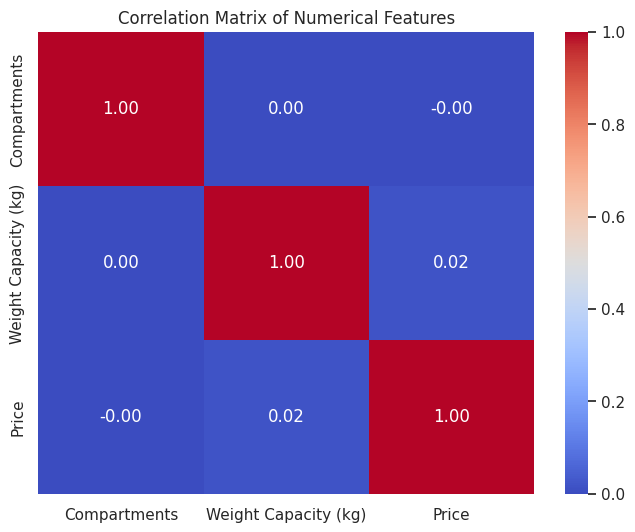

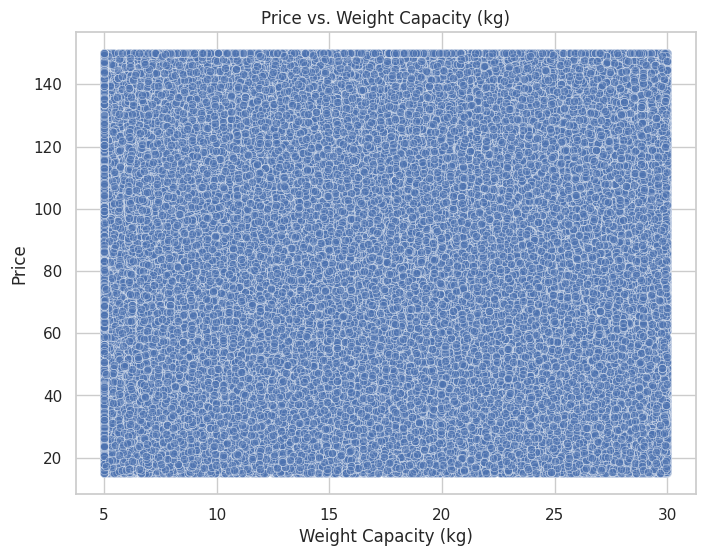

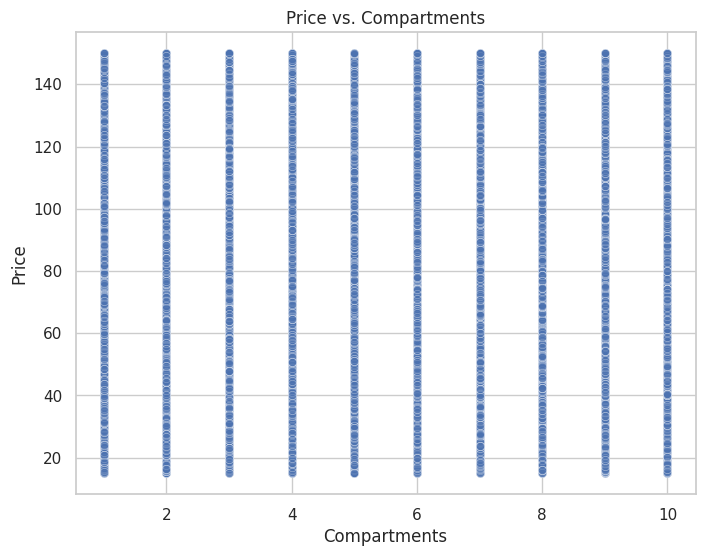

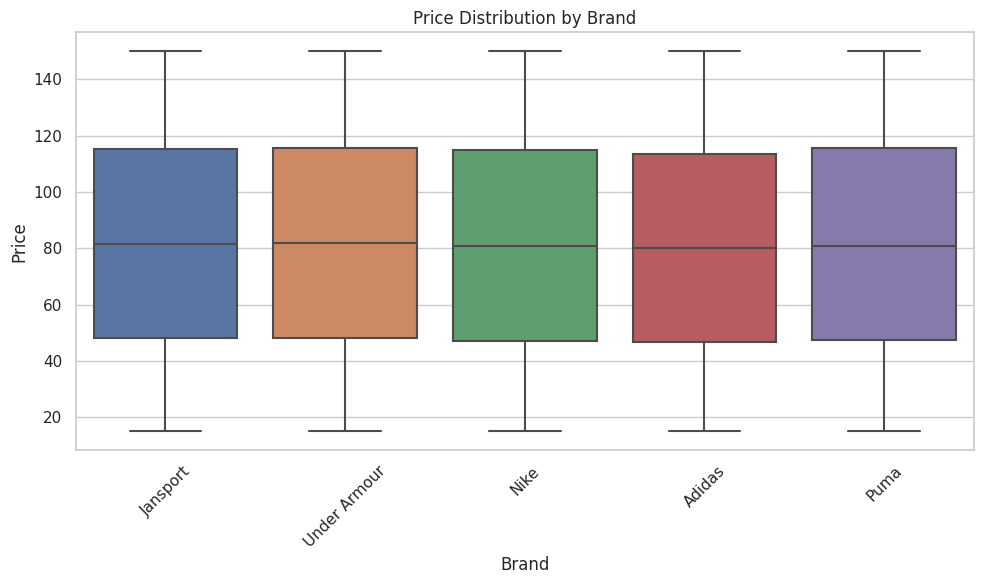

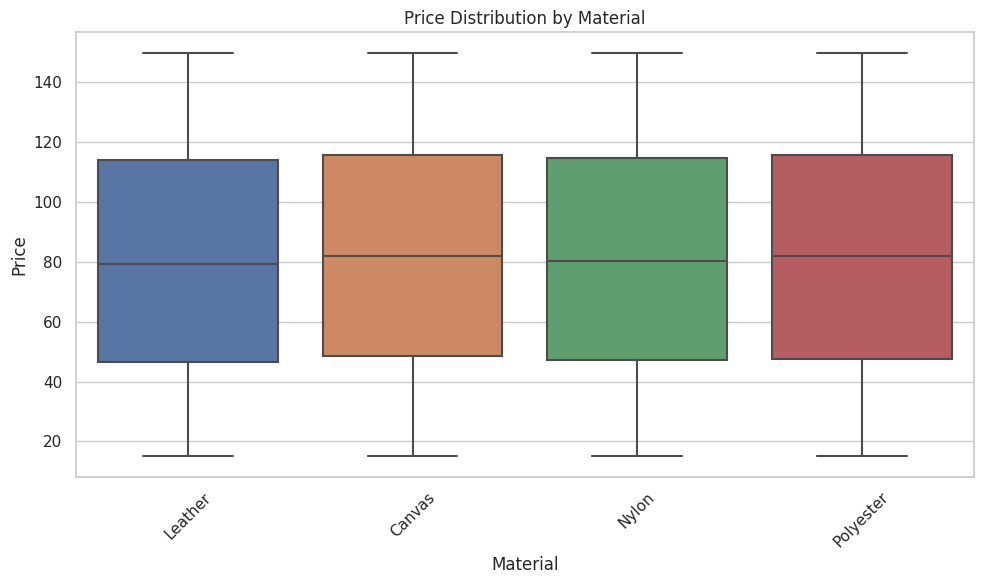

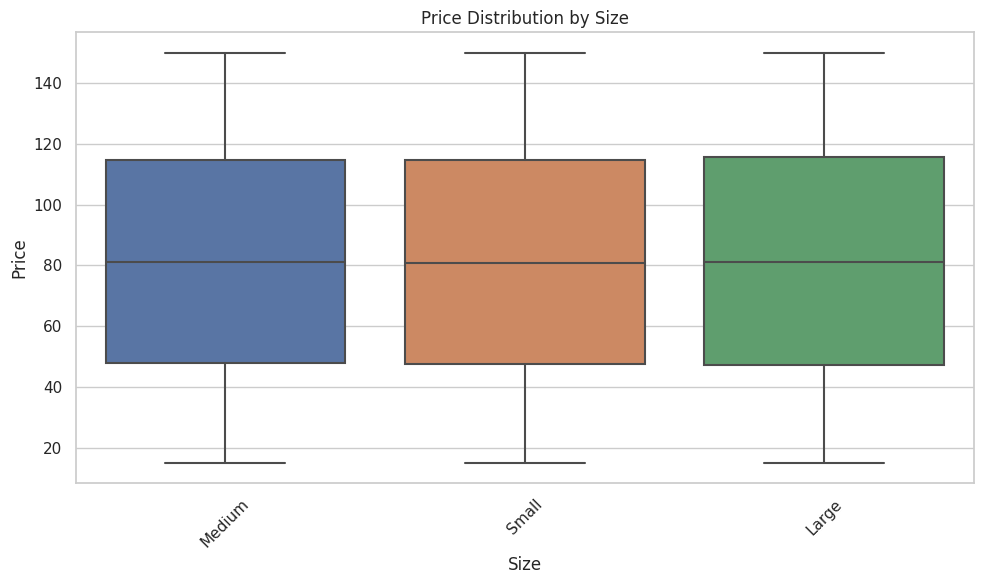

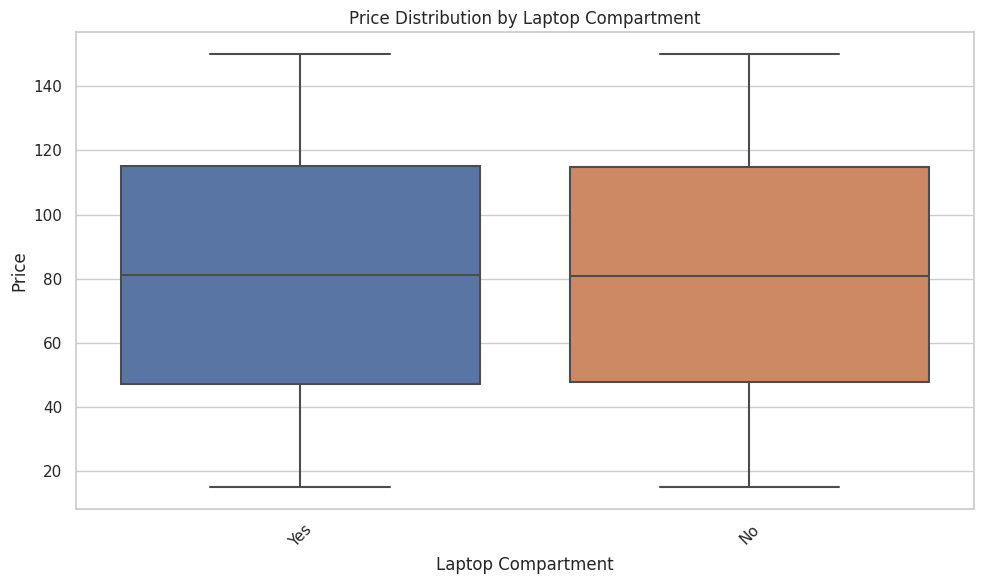

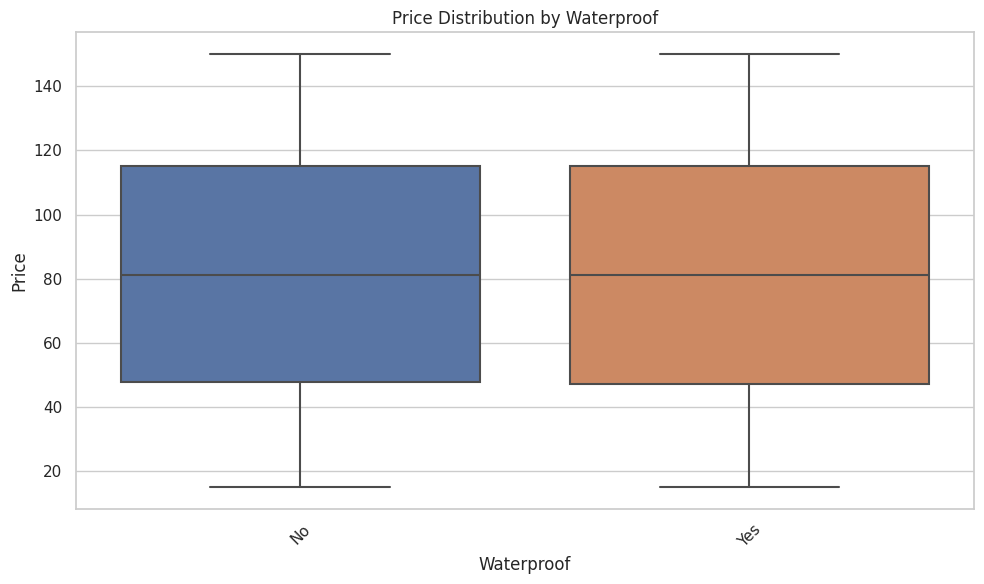

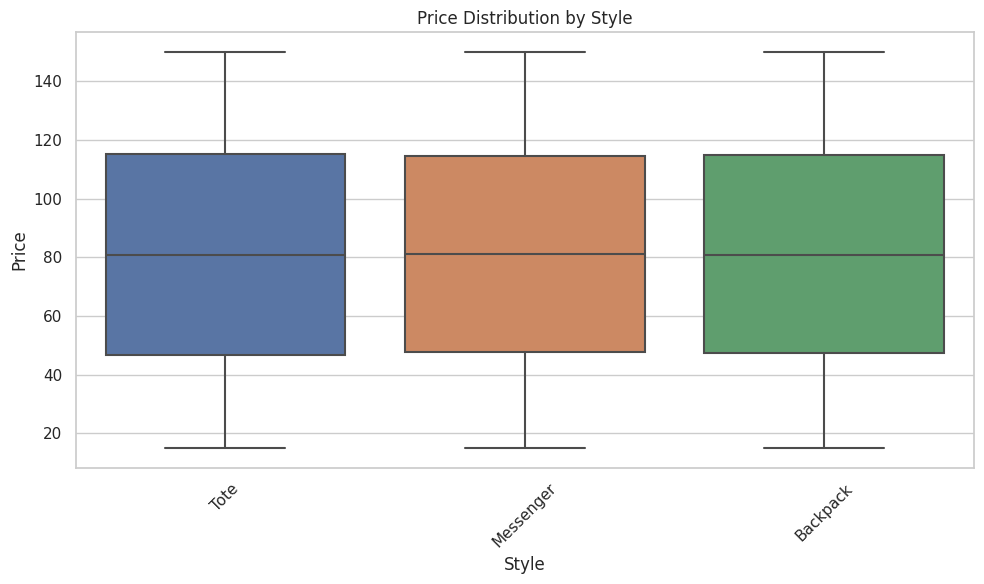

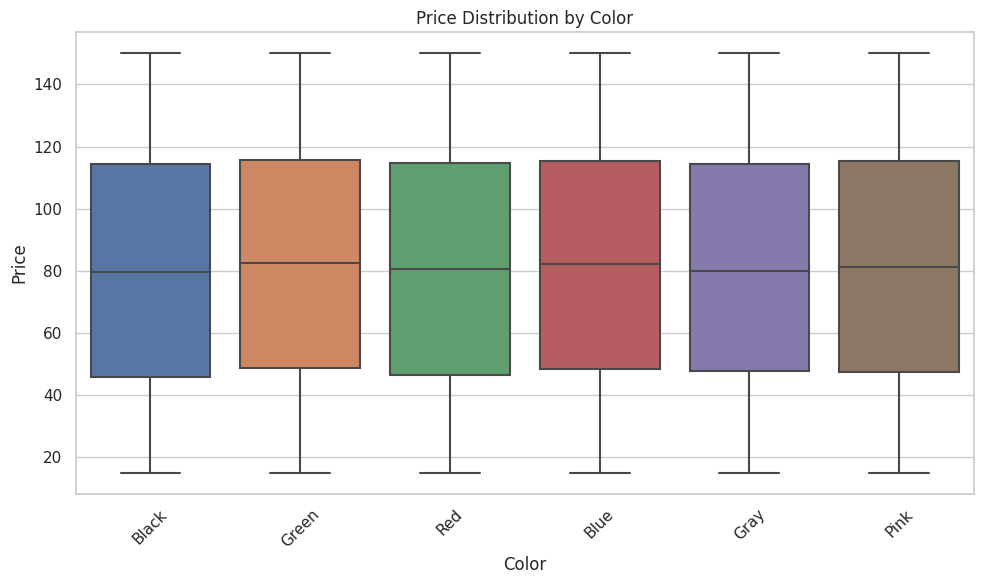

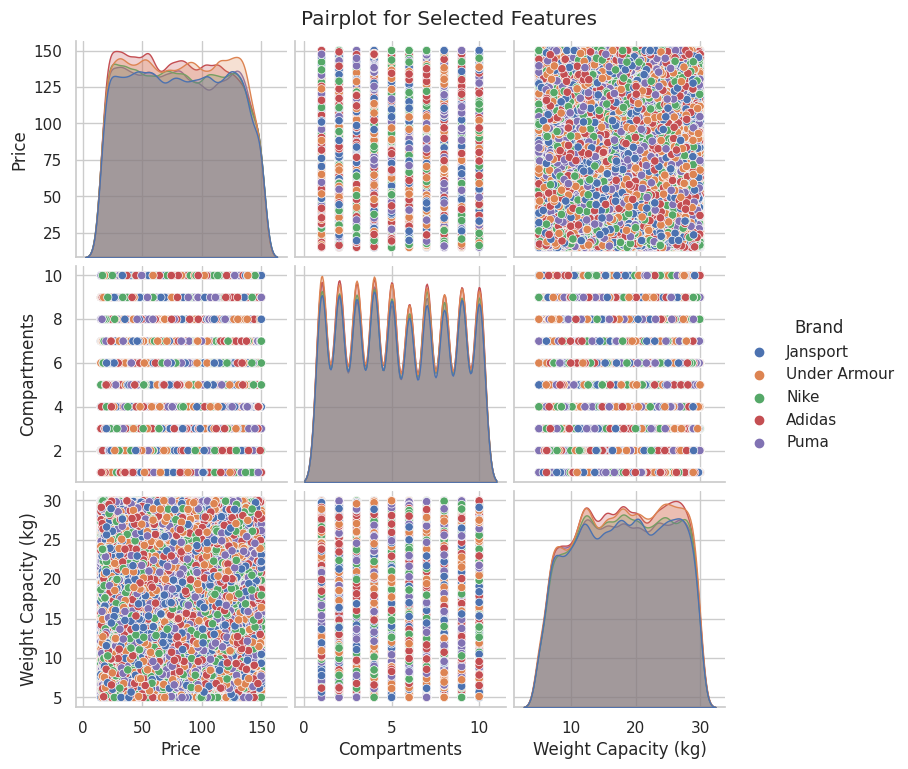

In [29]:
# warning when adding code template to the prompt you have to be careful about the formating. If the code is place as is in the template some might be
# interpreted as variables by the langchain prompt parser

code_template = """

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded in train_data
# Drop the id column
data = train_data.drop(columns=['id'])

# -------------------------------
# 1. Correlation Analysis for Numerical Features
# -------------------------------
# Select numerical columns (Price, Compartments, Weight Capacity (kg))
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# -------------------------------
# 2. Scatter Plots for Continuous Features vs. Price
# -------------------------------
# Scatter plot: Price vs Weight Capacity (kg)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Weight Capacity (kg)', y='Price', data=data, alpha=0.5)
plt.title("Price vs. Weight Capacity (kg)")
plt.xlabel("Weight Capacity (kg)")
plt.ylabel("Price")
plt.show()

# Scatter plot: Price vs Compartments
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compartments', y='Price', data=data, alpha=0.5)
plt.title("Price vs. Compartments")
plt.xlabel("Compartments")
plt.ylabel("Price")
plt.show()

# -------------------------------
# 3. Boxplots for Categorical Features vs. Price
# -------------------------------
# List of relevant categorical features
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

# Iterate over each categorical variable and create boxplots
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y="Price", data=data)
    plt.title(f"Price Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 4. Pairplot to Get an Overall View of Relationships (including Price)
# -------------------------------
# For a multivariate perspective, select a subset of features
# (If plotting all 11 columns becomes cluttered, consider reducing to select features)
subset_features = ['Price', 'Compartments', 'Weight Capacity (kg)'] + categorical_features[:2]  # using only two of the categorical for clarity
sns.pairplot(data[subset_features], hue="Brand", diag_kind="kde")
plt.suptitle("Pairplot for Selected Features", y=1.02)
plt.show()
"""



template_features = """The aim of this EDA is to understand the impact of several variables on Price. See below the EDA summary:
{context}

Please create Python code to perform the multivariate analyse using seaborn and matplotlib. The dataset is stored in memory in train_data.
- The target variable is Price
- Ignore the id column. 
Put your python code inside a ```python``` block.

example code template
{code_template}
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke({"context": summary_json, "code_template": code_template})

display(Markdown(result))

match = re.search(r"```python\s*(.*?)\s*```", result, re.DOTALL)
if match:
    python_code = match.group(1)
    # Execute the extracted Python code
    exec(python_code)
else:
    print("No Python code block found.")

- **The multivariables plots seems to indicate that the Price columns is only noise!**
- **see this discussion: [The target is just noise?](https://www.kaggle.com/competitions/playground-series-s5e2/discussion/560669)**

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Generate Feature engineering ideas</div>

In [30]:
# Generate EDA summary and format it as a JSON string
summary = eda_summary(train_data)
summary_json = json.dumps(summary, indent=4, default=str)  # summary_json is now a single string

# Prepare the first few rows of train and test data as strings
train_data_head = train_data.head().to_string(index=False)
test_data_head = test_data.head().to_string(index=False)

# Define the prompt template with placeholders for dynamic values
template_features = """The aim of this exploratory data analysis (EDA) is to understand the impact of various variables on Price. Below is the EDA summary:
{context}

Please generate Python code for feature engineering to enhance the model’s performance based on the provided EDA summary.
Place your code into a ```python``` block.
Before the Python code create a few bullet points in the mardown format to explain your appraoch. Keep it short. (do not us any # symbols just bullet points -)
When handling missing values, take into consideration how much of the data is missing for each column and adapt the code based on this.
The datasets are preloaded in memory as `train_data` and `test_data`.
The feature engineering needs to be applied to both datasets in a way that avoids data leakage.
Be mindful of the fact that the data distribution in the train anb test data could be different and some categorical values present in the test data
could be abscent in the train data. The code will need to that into consideration.

The final transformed datasets should be called: train_data_processed and test_data_processed.

First rows of the train data:
{train_data_head}

First rows of the test data:
{test_data_head}
"""

# Create the ChatPromptTemplate
prompt = ChatPromptTemplate.from_template(template_features)

# Define the LLM model and output parser
output_parser = StrOutputParser()

# Chain components together
chain = prompt | model | output_parser

# Prepare the input as a dictionary with `context`, `train_data_head`, and `test_data_head`
input_data = {
    "context": summary_json,
    "train_data_head": train_data_head,
    "test_data_head": test_data_head
}

# Format the prompt with the input data for troubleshooting
formatted_prompt = prompt.format(
    context=summary_json,
    train_data_head=train_data_head,
    test_data_head=test_data_head
)

# Print the formatted prompt for troubleshooting
#print("Formatted Prompt for Troubleshooting:\n")
#print(formatted_prompt)

# Now proceed with invoking the chain
result = chain.invoke(input_data)

# Display the result as Markdown
display(Markdown(result))

- Use the training set to compute imputation values (median for numeric, mode for categorical) and apply these to both train and test sets.
- One‐hot encode the categorical features using the training set’s categories and then align the test set to match.
- Avoid data leakage by basing all imputation and encoding decisions on training data only.

```python
import pandas as pd
import numpy as np

# Make copies of the original data to avoid modifying them directly
train_data_processed = train_data.copy()
test_data_processed = test_data.copy()

# Define columns based on the EDA
numeric_cols = ["Compartments", "Weight Capacity (kg)"]
categorical_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

# 1. Impute missing values using training set statistics

# For numeric columns, impute missing values with the median from train data
num_impute_values = {}
for col in numeric_cols:
    median_value = train_data_processed[col].median()
    num_impute_values[col] = median_value
    train_data_processed[col] = train_data_processed[col].fillna(median_value)
    test_data_processed[col] = test_data_processed[col].fillna(median_value)

# For categorical columns, impute missing values with the mode from train data
cat_impute_values = {}
for col in categorical_cols:
    # If all values are missing in a col in train (unlikely here), use a placeholder
    mode_value = train_data_processed[col].mode()[0] if not train_data_processed[col].mode().empty else "Missing"
    cat_impute_values[col] = mode_value
    train_data_processed[col] = train_data_processed[col].fillna(mode_value)
    test_data_processed[col] = test_data_processed[col].fillna(mode_value)

# 2. Feature engineering: Create dummies for categorical variables
# Use drop_first=True to avoid multicollinearity (if required)
train_data_processed = pd.get_dummies(train_data_processed, columns=categorical_cols, drop_first=True)
test_data_processed = pd.get_dummies(test_data_processed, columns=categorical_cols, drop_first=True)

# 3. Align the columns between train and test datasets.
# Exclude target column 'Price' from the alignment.
train_features = train_data_processed.drop("Price", axis=1)
train_data_processed, test_data_processed = train_data_processed.align(test_data_processed, join='left', axis=1, fill_value=0)

# After alignment, ensure the test data does not have a Price column
if "Price" in test_data_processed.columns:
    test_data_processed = test_data_processed.drop("Price", axis=1)

# Optional: Reorder test_data_processed columns to match train_data_processed (excluding Price)
train_feature_cols = train_data_processed.columns.drop("Price")
test_data_processed = test_data_processed.reindex(columns=train_feature_cols, fill_value=0)

# The final processed dataframes are now:
# train_data_processed and test_data_processed

# Display a summary of the processed train data (optional)
print("Train data processed shape:", train_data_processed.shape)
print("Test data processed shape:", test_data_processed.shape)
```

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Create a baseline model with AutoGluon</div>

- focus on tree based models

```python
# Preparing training data
# Drop 'id' column since it is not useful for training
train_data_processed = train_data.drop(columns=['id'])
```

```python
import tempfile
from autogluon.tabular import TabularPredictor

# Specify the target column and set it to 'Price'
target = 'Price'

# Create a temporary directory to avoid saving models to a permanent folder
temp_model_path = tempfile.mkdtemp()

# Define hyperparameters to include only tree-based models:
# - 'GBM': LightGBM-based model
# - 'CAT': CatBoost-based model
# - 'XGB': XGBoost-based model
# - 'RF':  Random Forest model
tree_based_hyperparameters = {
    'GBM': {},
    'CAT': {},
    'XGB': {},
    'RF': {}
}

# Train AutoGluon model with the desired adjustments, focusing exclusively on tree-based methods
predictor = TabularPredictor(label=target, eval_metric='rmse', path=temp_model_path).fit(
    train_data_processed,
    hyperparameters=tree_based_hyperparameters,
    presets='best_quality',      # Using the best quality preset for higher accuracy
    time_limit=TIME_LIMIT,       # Control the training time (in seconds)
    num_bag_folds=10,            # Enable ensembling by using bagging with 10 folds
    num_stack_levels=2,          # Enable stacking to further improve model performance
    ag_args_fit={'use_gpu': False},  # Set to True if using GPU for model training
    verbosity=0                  # Suppress logging output (0: most silent, 4: most detailed)
)
```

```python
# Review the leaderboard of different models trained by AutoGluon

leaderboard = predictor.leaderboard(silent=True)
leaderboard.to_csv('leaderboard_1.csv', index=False)
leaderboard.head(10)
```

```python
feature_importance = predictor.feature_importance(train_data_processed)
top_features = feature_importance.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(12, 10))
plt.barh(top_features.index, top_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance from AutoGluon Model')
plt.gca().invert_yaxis()
plt.show()
```

```python
from datetime import datetime

# Drop the 'id' column before making predictions
test_data_processed = test_data.drop(columns=['id'])

# Use AutoGluon to predict class labels (0 or 1) for 'depression'
y_test_pred = predictor.predict(test_data_processed)

# Create the submission file
sub1 = pd.DataFrame({
    'id': test_data['id'],
    'Depression': y_test_pred
})

# Generate a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the submission file with the timestamp
filename = f'm01_autogluon_sub_{timestamp}.csv'
sub1.to_csv(filename, index=False)

print(f"Submission file saved as: {filename}")
```

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Create a baseline model with o3-mini-high</div>

In [31]:
MAX_ITERATIONS = 2
TARGET_SCORE = 45

In [32]:
import traceback
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

In [33]:
metric = "RMSE"
train_data_path = "/kaggle/input/playground-series-s5e2/train.csv"
test_data_path = "/kaggle/input/playground-series-s5e2/test.csv"
submission_example_path = "/kaggle/input/playground-series-s5e2/sample_submission.csv"
submission_path = "/kaggle/working/submission.csv"
target_variable = 'Price'

train_data_summary_json = summary_json

# --------------------------------------------------------------------
# 1. Prepare your "initial" prompt
# --------------------------------------------------------------------
system_instructions = f"""
You are a coding assistant specialized in tabular data analysis. Here you must predict the Price. 
Output valid Python code that runs end to end.
"""

user_instructions = f"""
You are given the following dataset information:
- Train data path: {train_data_path}
- Test data path: {test_data_path}
- Submission example path: {submission_example_path}
- Train data summary: {train_data_summary_json}
- Target variable: {target_variable}
- Path to the final submission file: {submission_path}

**Task**:
2. Train a model to predict {target_variable}.
3. Generate a valid Kaggle submission at {submission_path}.
4. Compute the '{metric}' on a validation split and store it in 'val_rmse'.
5. Return *only* valid Python code, with no triple backticks.

Begin now.
"""

initial_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content=system_instructions),
    HumanMessage(content=user_instructions),
])

# --------------------------------------------------------------------
# 2. Prepare a "repair" prompt template
# --------------------------------------------------------------------
repair_prompt_template = """
The previous code caused an error or had unsatisfactory results. Below is the code that was generated:

--- CODE START ---
{previous_code}
--- CODE END ---

Here is the traceback or error message:

--- ERROR START ---
{error_trace}
--- ERROR END ---

**Task**:
- Train a model to predict Price.
- Generate a valid Kaggle submission at '/kaggle/working/submission.csv'.
- Compute the 'RMSE' on a validation split and store it in 'val_rmse'.
- Return *only* valid Python code, with no triple backticks.

Begin now.
"""

repair_chain_prompt = ChatPromptTemplate.from_template(repair_prompt_template)

# --------------------------------------------------------------------
# 3. Create your LLM & output parser
# --------------------------------------------------------------------
model_params = {
    "model": MODEL,
    "openai_api_key": OPENAI_API_KEY,
}
    
llm = ChatOpenAI(**model_params)
parser = StrOutputParser()

# --------------------------------------------------------------------
# 4. Helper Function to remove triple backticks
# --------------------------------------------------------------------
def remove_markdown_code_fences(code_str: str) -> str:
    """
    Remove triple-backtick fences from code.
    Also removes lines that contain them.
    """
    lines = code_str.splitlines()
    cleaned = []
    for line in lines:
        if "```" not in line:
            cleaned.append(line)
    return "\n".join(cleaned).strip()

# --------------------------------------------------------------------
# 5. Iterative generation logic
# --------------------------------------------------------------------
iteration = 0
success = False
current_code = None

while iteration < MAX_ITERATIONS and not success:
    iteration += 1
    print(f"\n--- Attempt #{iteration} ---")

    if iteration == 1:
        # Use the initial chain
        chain = initial_prompt_template | llm | parser
        result_code = chain.invoke({
            "train_path": train_data_path,
            "test_path": test_data_path,
            "submission_example_path": submission_example_path,
            "train_summary": train_data_summary_json,
            "target_variable": target_variable,
            "submission_path": submission_path,
            "metric": metric
        })
    else:
        # Use the repair chain with previous_code & error_trace
        # That chain is basically the repair_prompt_template + system_instructions if needed
        repair_chain = repair_chain_prompt | llm | parser
        result_code = repair_chain.invoke({
            "previous_code": current_code,
            "error_trace": error_message,
            "metric": metric
        })
    # Clean out triple backticks
    cleaned_code = remove_markdown_code_fences(result_code)
    current_code = cleaned_code  # store for next iteration if needed

    print("--- Generated/Corrected Code Start ---")
    print(cleaned_code)
    print("--- Generated/Corrected Code End ---\n")

    # Attempt to exec the code
    local_namespace = {}
    try:
        exec(cleaned_code, {}, local_namespace)

        # Check if there's a val_mape and if it is numeric
        if "val_rmse" in local_namespace:
            val_rmse = local_namespace["val_rmse"]
            print(f"val_rmse from script: {val_rmse}")
            if val_rmse < TARGET_SCORE:
                success = True
            else:
                error_message = f"RMSE {val_rmse} is above threshold"
                print(error_message)
                continue
        success = True
    except Exception as e:
        error_trace = traceback.format_exc()
        print("Error encountered while running the generated code:")
        print(error_trace)
        error_message = error_trace  # store for next iteration
        # Not success, continue the loop

if not success:
    print("\nMax iterations reached. Still failing. Exiting.\n")
else:
    print("\nProcess completed successfully!")


--- Attempt #1 ---
--- Generated/Corrected Code Start ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Load data
train_data = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Define features and target
# We'll use all features except 'id' and 'Price'
features = ["Brand", "Material", "Size", "Compartments", "Laptop Compartment",
            "Waterproof", "Style", "Color", "Weight Capacity (kg)"]
target = "Price"

# Split train data into training and validation sets
X = train_data[features]
y = train_data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
num

In [34]:
import datetime
timesampt = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
!cp /kaggle/working/submission.csv /kaggle/working/m02_o3_mini_$timesampt.csv

cp: cannot stat '/kaggle/working/submission.csv': No such file or directory
